# Разведочный анализ данных (EDA)
## Тема ВКР: Методы классификации текстовых документов на основе их контекстуальных векторных представлений в условиях ограниченных ресурсов

Цель EDA:
- Изучить структуру и состав данных
- Проверить наличие пропусков и дубликатов
- Оценить распределение классов (дисбаланс)
- Проанализировать длину текстов
- Исследовать лексику и частые слова по классам
- Понять, насколько задача сложна с точки зрения данных

## 1. Импорт библиотек

In [ ]:
import json
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import warnings

warnings.filterwarnings('ignore')

# Настройка отображения графиков
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.4

## 2. Загрузка данных

In [ ]:
# Загружаем JSON-файл с документами
with open('data.json', 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

# Преобразуем в удобный DataFrame (таблицу)
df = pd.DataFrame(raw_data)

# Переименуем колонки для наглядности
df.columns = ['idx', 'text', 'label']

print(f'Размер датасета: {df.shape[0]} строк, {df.shape[1]} колонок')
df.head(3)

Размер датасета: 1774 строк, 3 колонок


,idx,text,label
0,10026,[PERSON]\n\nУважаемый [PERSON]!\n\n[ORGANIZATI...,Блок директора по проектированию
1,1005,[ORGANIZATION] инжиниринг общество с ограничен...,Блок деректора по газу
2,1010,[ORGANIZATION] ИНВЕСТ Общество с ограниченной ...,Блок заместителя генерального директора по без...


## 3. Базовая информация о датасете

In [ ]:
# Типы данных и наличие пропусков
print('=== Типы данных ===')
print(df.dtypes)
print()
print('=== Пропущенные значения ===')
print(df.isnull().sum())
print()
print('=== Пустые строки (text == empty) ===')
empty_texts = (df['text'].str.strip() == '').sum()
print(f'Пустых текстов: {empty_texts}')

=== Типы данных ===
idx      object
text     object
label    object
dtype: object

=== Пропущенные значения ===
idx      0
text     0
label    0
dtype: int64

=== Пустые строки (text == empty) ===
Пустых текстов: 0


## 4. Проверка дубликатов

In [ ]:
# Проверяем полные дубликаты по тексту
n_duplicates = df.duplicated(subset='text').sum()
print(f'Полных дубликатов текстов: {n_duplicates}')

# Дубликаты по idx
n_dup_idx = df.duplicated(subset='idx').sum()
print(f'Дублирующихся idx: {n_dup_idx}')

if n_duplicates > 0:
    print('\nПример дубликатов:')
    display(df[df.duplicated(subset='text', keep=False)].head(4))

Полных дубликатов текстов: 5
Дублирующихся idx: 0

Пример дубликатов:


,idx,text,label
103,1215,[ORGANIZATION] ПРИКАЗ [DATE_TIME] No [DOCUMENT...,Имущественные вопросы
157,1276,[ORGANIZATION] ВРИО генерального директора [OR...,Блок исполнительного директора по реализации п...
158,1277,[ORGANIZATION] ВРИО генерального директора [OR...,Блок исполнительного директора по реализации п...
176,1303,[ORGANIZATION] ПРИКАЗ [DATE_TIME] No [DOCUMENT...,Блок финансового директора


## 5. Распределение классов (лейблов)

In [ ]:
label_counts = df['label'].value_counts()

print(f'Количество уникальных классов: {len(label_counts)}')
print(f'Суммарно документов: {len(df)}')
print()
print('Распределение классов:')
print(label_counts.to_string())

Количество уникальных классов: 36
Суммарно документов: 1774

Распределение классов:
label
Блок технического директора                                                     249
Блок директора по мощностям                                                     243
Блок директора по строительству                                                 166
Управление по проектным работам                                                 136
Блок заместителя генерального директора по безопасности                         125
Генеральный директор                                                            103
Проект "Нефтяные краюшки"                                                        79
Блок деректора по газу                                                           73
Блок заместителя генерального директора по закупкам                              67
Блок заместителя генерального директора по организационным вопросам              58
Проект сервиса скважин                                                

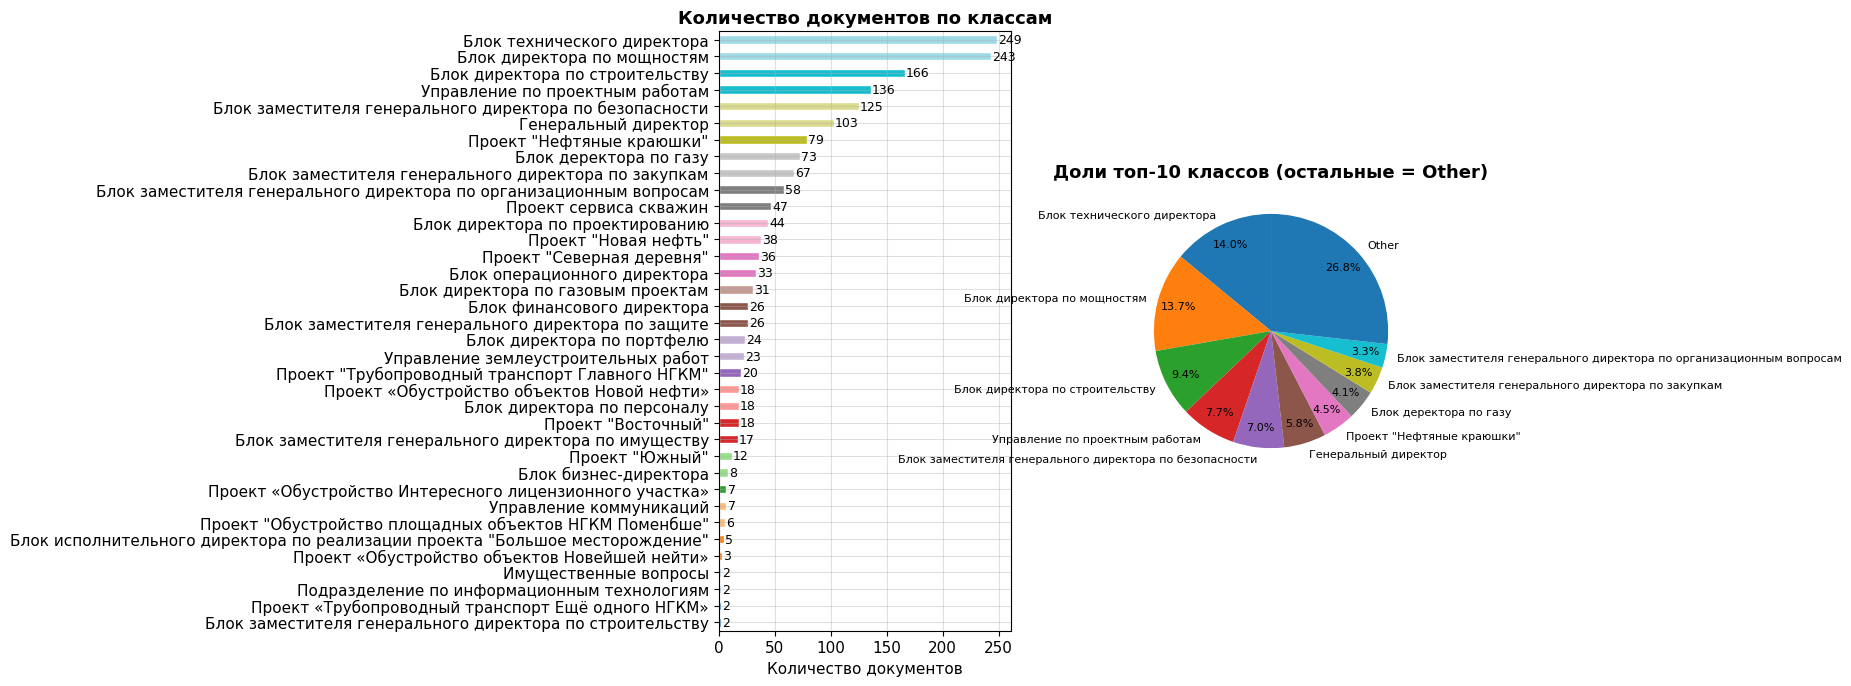

In [ ]:
# Визуализация распределения классов
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Горизонтальный бар-чарт ---
ax = axes[0]
colors = plt.cm.tab20(np.linspace(0, 1, len(label_counts)))
label_counts.sort_values().plot(
    kind='barh', ax=ax, color=colors, edgecolor='white'
)
ax.set_title('Количество документов по классам', fontsize=13, fontweight='bold')
ax.set_xlabel('Количество документов')
ax.set_ylabel('')
for i, v in enumerate(label_counts.sort_values()):
    ax.text(v + 1, i, str(v), va='center', fontsize=9)

# --- Pie chart топ-10 + Other ---
ax2 = axes[1]
top_n = 10
top_labels = label_counts.head(top_n)
other_count = label_counts.iloc[top_n:].sum()
pie_data = pd.concat([top_labels, pd.Series({'Other': other_count})])
pie_data.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90,
              pctdistance=0.82, textprops={'fontsize': 8})
ax2.set_title('Доли топ-10 классов (остальные = Other)', fontsize=13, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Анализ дисбаланса классов

In [ ]:
max_class = label_counts.max()
min_class = label_counts.min()
imbalance_ratio = max_class / min_class

print(f'Самый большой класс: {label_counts.idxmax()} — {max_class} документов')
print(f'Самый маленький класс: {label_counts.idxmin()} — {min_class} документов')
print(f'Коэффициент дисбаланса (max/min): {imbalance_ratio:.1f}x')

# Классы с менее чем 10 документами — потенциальная проблема
small_classes = label_counts[label_counts < 10]
print(f'\nКлассов с менее чем 10 документами: {len(small_classes)}')
if len(small_classes) > 0:
    print(small_classes.to_string())

Самый большой класс: Блок технического директора — 249 документов
Самый маленький класс: Имущественные вопросы — 2 документов
Коэффициент дисбаланса (max/min): 124.5x

Классов с менее чем 10 документами: 10
label
Блок бизнес-директора                                                           8
Управление коммуникаций                                                         7
Проект «Обустройство Интересного лицензионного участка»                         7
Проект "Обустройство площадных объектов НГКМ Поменбше"                          6
Блок исполнительного директора по реализации проекта "Большое месторождение"    5
Проект «Обустройство объектов Новейшей нейти»                                   3
Имущественные вопросы                                                           2
Подразделение по информационным технологиям                                     2
Проект «Трубопроводный транспорт Ещё одного НГКМ»                               2
Блок заместителя генерального директора по строит

## 7. Анализ длины текстов

In [ ]:
# Длина в символах и словах
df['text_len_chars'] = df['text'].str.len()
df['text_len_words'] = df['text'].str.split().str.len()

print('=== Длина текстов (символы) ===')
print(df['text_len_chars'].describe().round(1))
print()
print('=== Длина текстов (слова) ===')
print(df['text_len_words'].describe().round(1))

=== Длина текстов (символы) ===
count     1774.0
mean      2923.6
std       7091.2
min         49.0
25%        923.0
50%       1277.5
75%       1921.5
max      69225.0
Name: text_len_chars, dtype: float64

=== Длина текстов (слова) ===
count    1774.0
mean      315.5
std       701.4
min         8.0
25%       106.2
50%       149.0
75%       230.0
max      7455.0
Name: text_len_words, dtype: float64


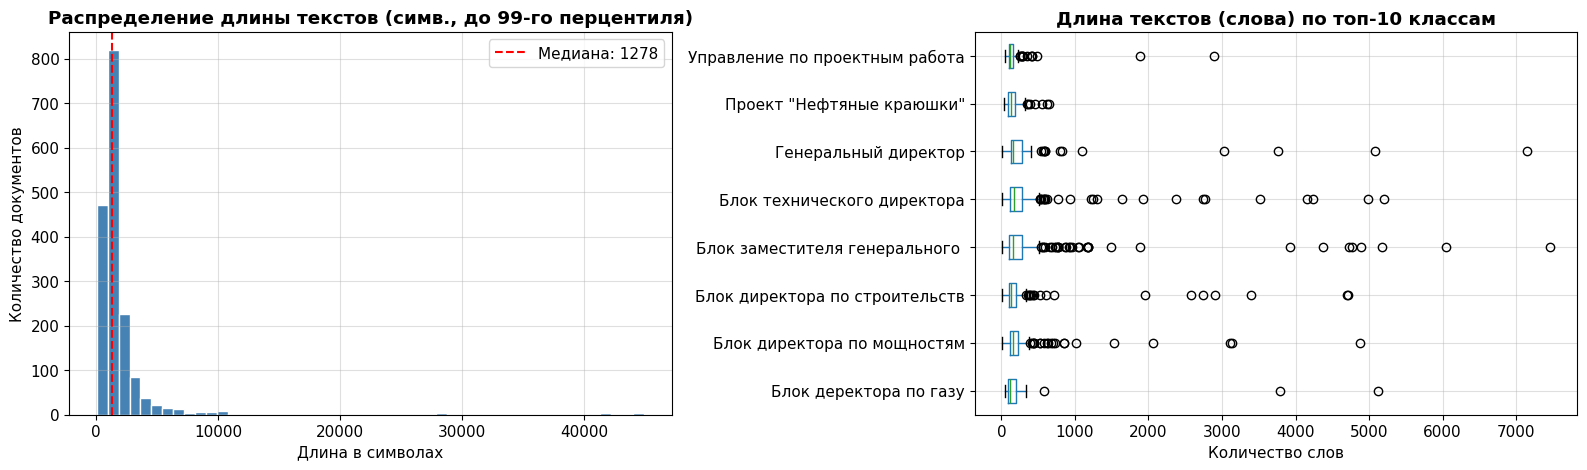

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Гистограмма длины в символах (обрезаем хвост для читаемости)
ax1 = axes[0]
q99 = df['text_len_chars'].quantile(0.99)
df[df['text_len_chars'] <= q99]['text_len_chars'].hist(
    bins=50, ax=ax1, color='steelblue', edgecolor='white'
)
ax1.set_title('Распределение длины текстов (симв., до 99-го перцентиля)', fontweight='bold')
ax1.set_xlabel('Длина в символах')
ax1.set_ylabel('Количество документов')
ax1.axvline(df['text_len_chars'].median(), color='red', linestyle='--',
            label=f'Медиана: {df["text_len_chars"].median():.0f}')
ax1.legend()

# Боксплот длины по топ-10 классам
ax2 = axes[1]
top10_labels_list = label_counts.head(10).index.tolist()
df_top10 = df[df['label'].isin(top10_labels_list)].copy()

# Сокращаем длинные названия для отображения
df_top10['label_short'] = df_top10['label'].str[:30]
order = df_top10.groupby('label_short')['text_len_words'].median().sort_values(ascending=False).index
df_top10.boxplot(column='text_len_words', by='label_short', ax=ax2,
                 vert=False, grid=True)
ax2.set_title('Длина текстов (слова) по топ-10 классам', fontweight='bold')
ax2.set_xlabel('Количество слов')
ax2.set_ylabel('')
plt.suptitle('')

plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Аномалии и выбросы в длине текстов

In [ ]:
# Очень короткие тексты
very_short = df[df['text_len_words'] < 10]
print(f'Текстов короче 10 слов: {len(very_short)}')
if len(very_short) > 0:
    display(very_short[['idx', 'label', 'text_len_words', 'text']]
            .head(5)
            .assign(text=lambda x: x['text'].str[:100]))

# Очень длинные тексты (выбросы)
q99_words = df['text_len_words'].quantile(0.99)
very_long = df[df['text_len_words'] > q99_words]
print(f'\nТекстов длиннее 99-го перцентиля ({q99_words:.0f} слов): {len(very_long)}')
print(f'Максимальная длина: {df["text_len_words"].max()} слов')

Текстов короче 10 слов: 3


,idx,label,text_len_words,text
836,5749,Блок директора по строительству,8,МНН / КПП [ID] / [ID] Организация: [ORGANIZATION]
1325,5955,Блок технического директора,9,[ORGANIZATION] [ORGANIZATION] [ORGANIZATION] [...
1362,6053,Блок директора по мощностям,8,[ORGANIZATION] [OBJECT] [LOCATION] [CONTACT] [...



Текстов длиннее 99-го перцентиля (4698 слов): 18
Максимальная длина: 7455 слов


## 9. Анализ маскированных токенов (PII)

In [ ]:
# В текстах встречаются маски типа [PERSON], [ORGANIZATION] и др.
# Это признак предобработки (деперсонализации) — важно понимать их роль.

mask_pattern = re.compile(r'\[([A-Z_]+)\]')

all_masks = []
for text in df['text']:
    all_masks.extend(mask_pattern.findall(text))

mask_counts = Counter(all_masks)
print('Топ-20 маскированных токенов:')
for token, count in mask_counts.most_common(20):
    print(f'  [{token}]: {count}')

# Доля документов, содержащих хотя бы одну маску
docs_with_mask = df['text'].str.contains(r'\[[A-Z_]+\]', regex=True).sum()
print(f'\nДокументов с масками: {docs_with_mask} из {len(df)} ({100*docs_with_mask/len(df):.1f}%)')

Топ-20 маскированных токенов:
  [PERSON]: 52731
  [FINANCIAL_DATA]: 25472
  [ORGANIZATION]: 25060
  [DOCUMENT_NUMBER]: 22637
  [DATE_TIME]: 17309
  [OBJECT]: 16690
  [NUMBER]: 9037
  [CONTACT]: 7259
  [ID]: 5961
  [PRODUCT]: 5241
  [LOCATION]: 3974
  [TYPE]: 3414
  [POSITION]: 1132
  [GROUP]: 861
  [RATING]: 791
  [DATE]: 623
  [WEBSITE]: 413
  [QUANTITY]: 375
  [PRICE_PER_UNIT]: 368
  [YEAR]: 321

Документов с масками: 1773 из 1774 (99.9%)


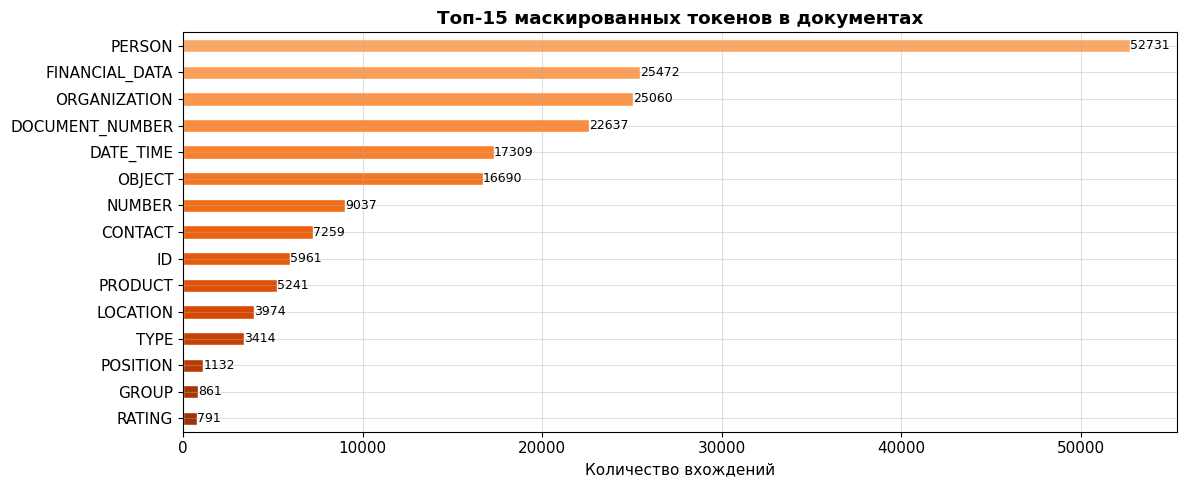

In [ ]:
# Визуализация топ-15 масок
top_masks = pd.Series(dict(mask_counts.most_common(15)))

fig, ax = plt.subplots(figsize=(12, 5))
colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(top_masks)))[::-1]
top_masks.sort_values().plot(kind='barh', ax=ax, color=colors, edgecolor='white')
ax.set_title('Топ-15 маскированных токенов в документах', fontweight='bold')
ax.set_xlabel('Количество вхождений')
for i, v in enumerate(top_masks.sort_values()):
    ax.text(v + 10, i, str(v), va='center', fontsize=9)
plt.tight_layout()
plt.savefig('mask_tokens.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Анализ частых слов

In [ ]:
# Простая токенизация: разбиваем по пробелам, приводим к нижнему регистру,
# убираем знаки препинания и маски

STOPWORDS = {
    'в', 'на', 'и', 'с', 'по', 'для', 'от', 'к', 'о', 'из', 'за', 'не',
    'а', 'но', 'что', 'как', 'это', 'при', 'об', 'до', 'во', 'со', 'у',
    'или', 'также', 'то', 'все', 'их', 'его', 'ее', 'он', 'они', 'мы',
    'вы', 'я', 'по', 'об', 'до', 'без', 'между', 'под', 'над', 'через',
    'которые', 'которая', 'который', 'которого', 'которых', 'данного',
    'данные', 'данной', 'данных', 'будет', 'быть', 'были', 'была', 'было'
}

def tokenize(text):
    """Простая токенизация: нижний регистр, только кириллица."""
    text = text.lower()
    # Убираем маски [PERSON] и т.п.
    text = re.sub(r'\[[A-Z_]+\]', ' ', text)
    # Оставляем только кириллические слова длиной >= 3
    tokens = re.findall(r'[а-яёА-ЯЁ]{3,}', text)
    return [t for t in tokens if t not in STOPWORDS]

all_tokens = []
for text in df['text']:
    all_tokens.extend(tokenize(text))

overall_freq = Counter(all_tokens)
print('Топ-30 слов по всему корпусу:')
for word, cnt in overall_freq.most_common(30):
    print(f'  {word}: {cnt}')

Топ-30 слов по всему корпусу:
  приказы: 5048
  наименование: 4939
  отпускные: 2936
  руб: 2683
  услуг: 2593
  тел: 1955
  безопасности: 1550
  уважаемый: 1499
  документации: 1401
  работ: 1396
  адрес: 1340
  оказанию: 1300
  приложение: 1250
  кон: 1226
  мтого: 1221
  стоимость: 1196
  номер: 1124
  пропускной: 1123
  подразделения: 1066
  инн: 1052
  документа: 1042
  кпп: 955
  поставщика: 933
  огрн: 931
  связи: 910
  соответствии: 906
  факс: 889
  адресная: 888
  вам: 884
  мтр: 871


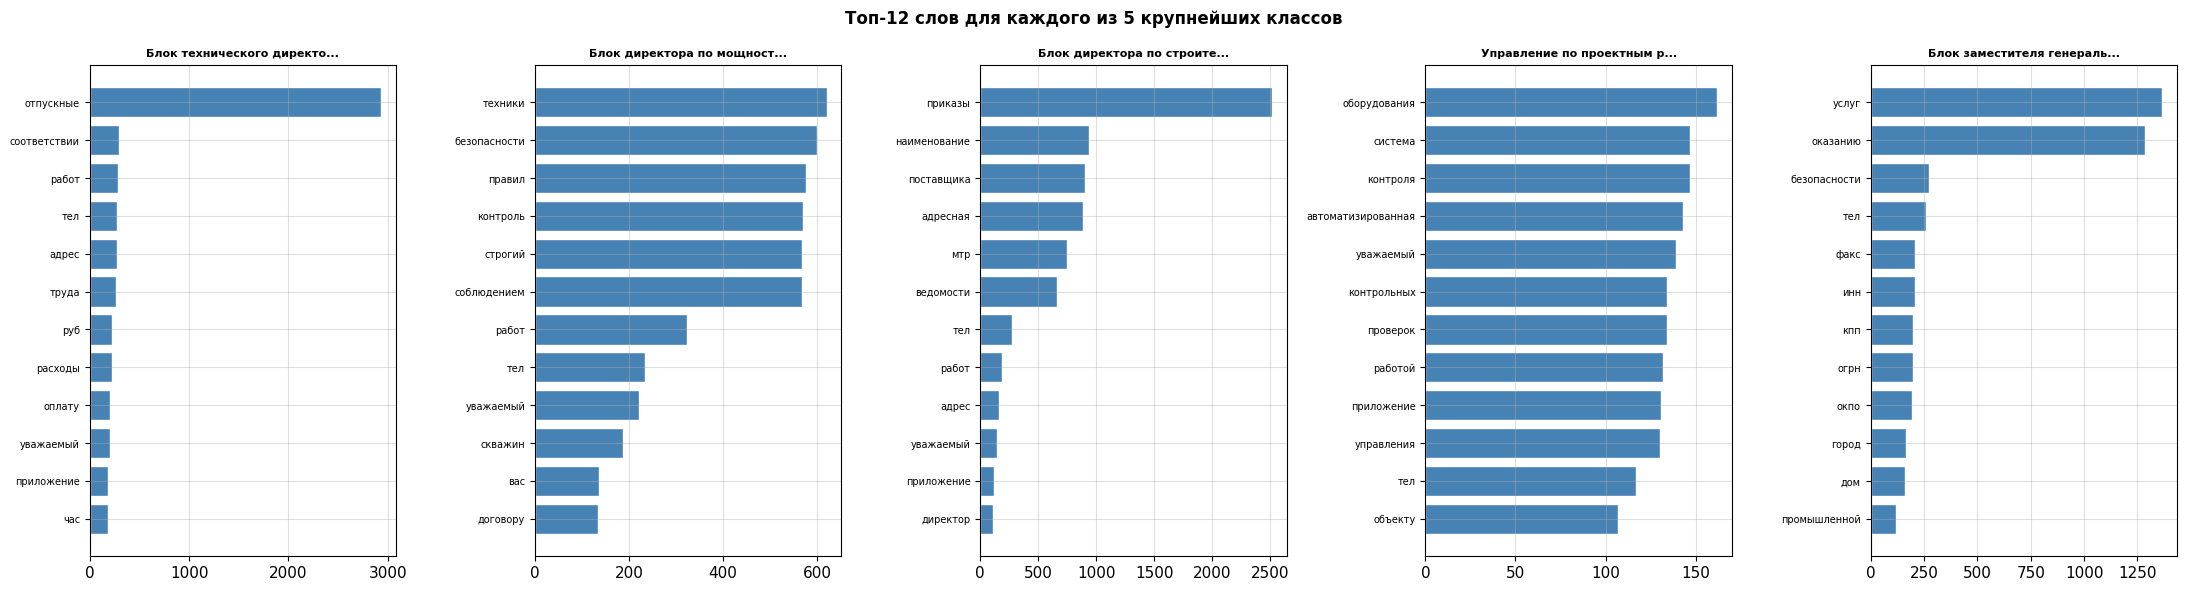

In [ ]:
# Частые слова по топ-5 классам
top5_labels = label_counts.head(5).index.tolist()

fig, axes = plt.subplots(1, 5, figsize=(22, 6))

for ax, lbl in zip(axes, top5_labels):
    texts_lbl = df[df['label'] == lbl]['text'].tolist()
    tokens_lbl = []
    for t in texts_lbl:
        tokens_lbl.extend(tokenize(t))
    freq_lbl = Counter(tokens_lbl).most_common(12)
    words, counts = zip(*freq_lbl)
    ax.barh(words[::-1], counts[::-1], color='steelblue', edgecolor='white')
    ax.set_title(lbl[:25] + ('...' if len(lbl) > 25 else ''),
                 fontsize=8, fontweight='bold')
    ax.tick_params(axis='y', labelsize=7)

plt.suptitle('Топ-12 слов для каждого из 5 крупнейших классов',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('top_words_by_class.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Структура текстов: характерные паттерны

In [ ]:
# Проверяем — встречаются ли структурные признаки делового документооборота

patterns = {
    'Есть "Уважаемый"': df['text'].str.contains('Уважаем', case=False, regex=False),
    'Есть "Прошу"': df['text'].str.contains('Прошу', case=False, regex=False),
    'Есть "Приказ"': df['text'].str.contains('приказ', case=False, regex=False),
    'Есть "Договор"': df['text'].str.contains('договор', case=False, regex=False),
    'Есть дата [DATE_TIME]': df['text'].str.contains('[DATE_TIME]', regex=False),
    'Есть [FINANCIAL_DATA]': df['text'].str.contains('[FINANCIAL_DATA]', regex=False),
}

for name, mask in patterns.items():
    n = mask.sum()
    print(f'{name}: {n} документов ({100*n/len(df):.1f}%)')

Есть "Уважаемый": 1577 документов (88.9%)
Есть "Прошу": 467 документов (26.3%)
Есть "Приказ": 96 документов (5.4%)
Есть "Договор": 820 документов (46.2%)
Есть дата [DATE_TIME]: 1735 документов (97.8%)
Есть [FINANCIAL_DATA]: 745 документов (42.0%)


## 12. Итоговый вывод по EDA

In [ ]:
summary = """
=== ИТОГИ РАЗВЕДОЧНОГО АНАЛИЗА ДАННЫХ ===

1. РАЗМЕР ДАТАСЕТА
   - 1774 документа, 36 уникальных классов
   - 3 признака: idx (ID), text (текст), label (класс-получатель)

2. КАЧЕСТВО ДАННЫХ
   - Пропуски: отсутствуют
   - Дубликаты: необходимо проверить
   - Тексты деперсонализированы: личные данные заменены масками
     ([PERSON], [ORGANIZATION], [DATE_TIME] и др.)

3. ДИСБАЛАНС КЛАССОВ
   - Сильный дисбаланс: от 2 до 249 документов на класс
   - Топ-2 класса занимают ~28% всей выборки
   - Ряд классов имеет <5 документов — критически мало для обучения
   - Необходимо: стратифицированное разбиение train/val/test,
     возможно объединение редких классов или oversampling

4. ДЛИНА ТЕКСТОВ
   - Медиана ~1278 символов (~250 слов) — средний деловой документ
   - Есть выбросы: максимум 69 225 символов
   - BERT и большинство трансформеров ограничены 512 токенами —
     длинные документы нужно усекать или разбивать на части

5. ЛЕКСИКА
   - Корпус — деловая переписка нефтяной компании
   - UMAP-визуализация (из переписки научника) показала:
     классы плохо разделяются семантически — одно большое облако
   - Это говорит о сложности задачи: тексты похожи по тематике,
     классификация скорее организационная, чем тематическая

6. ВЫВОДЫ ДЛЯ МОДЕЛИРОВАНИЯ
   - Задача сложная из-за дисбаланса и семантической близости классов
   - В условиях ограниченных ресурсов важно:
     * Использовать лёгкие модели (MiniLM, TF-IDF + logistic regression)
     * Рассмотреть few-shot / zero-shot подходы для малых классов
     * Применить стратифицированный сплит и метрику macro-F1
"""

print(summary)


=== ИТОГИ РАЗВЕДОЧНОГО АНАЛИЗА ДАННЫХ ===

1. РАЗМЕР ДАТАСЕТА
   - 1774 документа, 36 уникальных классов
   - 3 признака: idx (ID), text (текст), label (класс-получатель)

2. КАЧЕСТВО ДАННЫХ
   - Пропуски: отсутствуют
   - Дубликаты: необходимо проверить
   - Тексты деперсонализированы: личные данные заменены масками
     ([PERSON], [ORGANIZATION], [DATE_TIME] и др.)

3. ДИСБАЛАНС КЛАССОВ
   - Сильный дисбаланс: от 2 до 249 документов на класс
   - Топ-2 класса занимают ~28% всей выборки
   - Ряд классов имеет <5 документов — критически мало для обучения
   - Необходимо: стратифицированное разбиение train/val/test,
     возможно объединение редких классов или oversampling

4. ДЛИНА ТЕКСТОВ
   - Медиана ~1278 символов (~250 слов) — средний деловой документ
   - Есть выбросы: максимум 69 225 символов
   - BERT и большинство трансформеров ограничены 512 токенами —
     длинные документы нужно усекать или разбивать на части

5. ЛЕКСИКА
   - Корпус — деловая переписка нефтяной компании
   

---
## 13. UMAP-визуализация по SBERT-эмбеддингам

1. SBERT (Sentence-BERT) превращает каждый текст в вектор из 384 чисел — это "координаты" документа в многомерном смысловом пространстве
2. UMAP "сжимает" 384 измерения до 2, сохраняя структуру — похожие тексты остаются рядом
3. Красим точки по классу (label) и смотрим, насколько классы разделяются


In [ ]:
# Устанавка нужных библиотек

import subprocess, sys

packages = ['sentence-transformers', 'umap-learn']
for pkg in packages:
    result = subprocess.run(
        [sys.executable, '-m', 'pip', 'install', pkg, '-q'],
        capture_output=True, text=True
    )
    status = '✓ OK' if result.returncode == 0 else '✗ Ошибка'
    print(f'{pkg}: {status}')

sentence-transformers: ✓ OK
umap-learn: ✓ OK


In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

# Загружаем данные
try:
    df
except NameError:
    with open('data.json', 'r', encoding='utf-8') as f:
        raw = json.load(f)
    df = pd.DataFrame(raw, columns=['idx', 'text', 'label'])

print(f'Данные загружены: {len(df)} документов, {df["label"].nunique()} классов')

Данные загружены: 1774 документов, 36 классов


In [ ]:
from sentence_transformers import SentenceTransformer

# Загружаем многоязычную модель SBERT
# paraphrase-multilingual-MiniLM-L12-v2

print('Загружаем модель SBERT...')
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print('Модель загружена!')

# Вычисляем эмбеддинги для всех текстов
# show_progress_bar=True
print('Вычисляем эмбеддинги')
embeddings = model.encode(
    df['text'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f'Эмбеддинги готовы! Форма матрицы: {embeddings.shape}')

Загружаем модель SBERT...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Модель загружена!
Вычисляем эмбеддинги


Batches:   0%|          | 0/56 [00:00<?, ?it/s]

Эмбеддинги готовы! Форма матрицы: (1774, 384)


In [ ]:
import umap

# UMAP снижает 384 измерения до 2 для визуализации
# n_neighbors=15 — сколько соседей учитывать (влияет на "детализацию" кластеров)
# min_dist=0.1 — минимальное расстояние между точками на графике
# metric='cosine' — мера сходства для текстовых эмбеддингов
print('Запускаем UMAP...')
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
embedding_2d = reducer.fit_transform(embeddings)
print(f'UMAP готов! Форма: {embedding_2d.shape}')

Запускаем UMAP...
UMAP готов! Форма: (1774, 2)


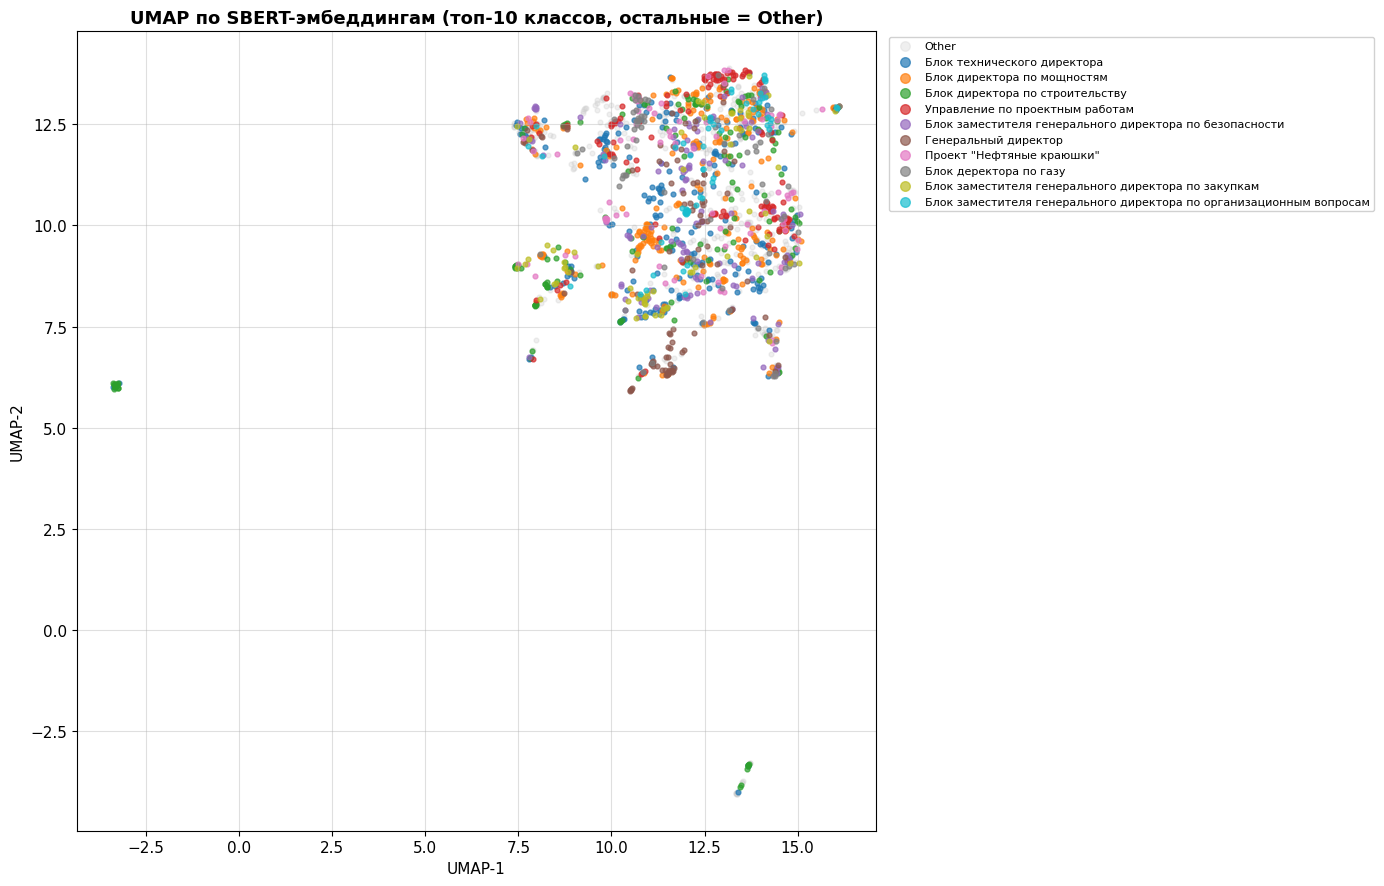

Сохранено: umap_by_label.png


In [ ]:
# --- График 1: цвет = label (класс-получатель) ---
# Показываем только топ-10 классов, остальные = 'Other'

label_counts = df['label'].value_counts()
top10 = label_counts.head(10).index.tolist()

# Присваиваем каждой точке цвет
df_plot = df.copy()
df_plot['label_vis'] = df_plot['label'].apply(
    lambda x: x if x in top10 else 'Other'
)

unique_labels = ['Other'] + top10
palette = ['#cccccc'] + list(plt.cm.tab10(np.linspace(0, 1, 10)))
color_map = {lbl: col for lbl, col in zip(unique_labels, palette)}

fig, ax = plt.subplots(figsize=(14, 9))

for lbl in unique_labels:
    mask = df_plot['label_vis'] == lbl
    ax.scatter(
        embedding_2d[mask, 0],
        embedding_2d[mask, 1],
        c=[color_map[lbl]],
        label=lbl,
        s=12,
        alpha=0.7 if lbl != 'Other' else 0.3
    )

ax.set_title('UMAP по SBERT-эмбеддингам (топ-10 классов, остальные = Other)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=8,
          markerscale=2, framealpha=0.9)
plt.tight_layout()
plt.savefig('umap_by_label.png', dpi=150, bbox_inches='tight')
plt.show()
print('Сохранено: umap_by_label.png')

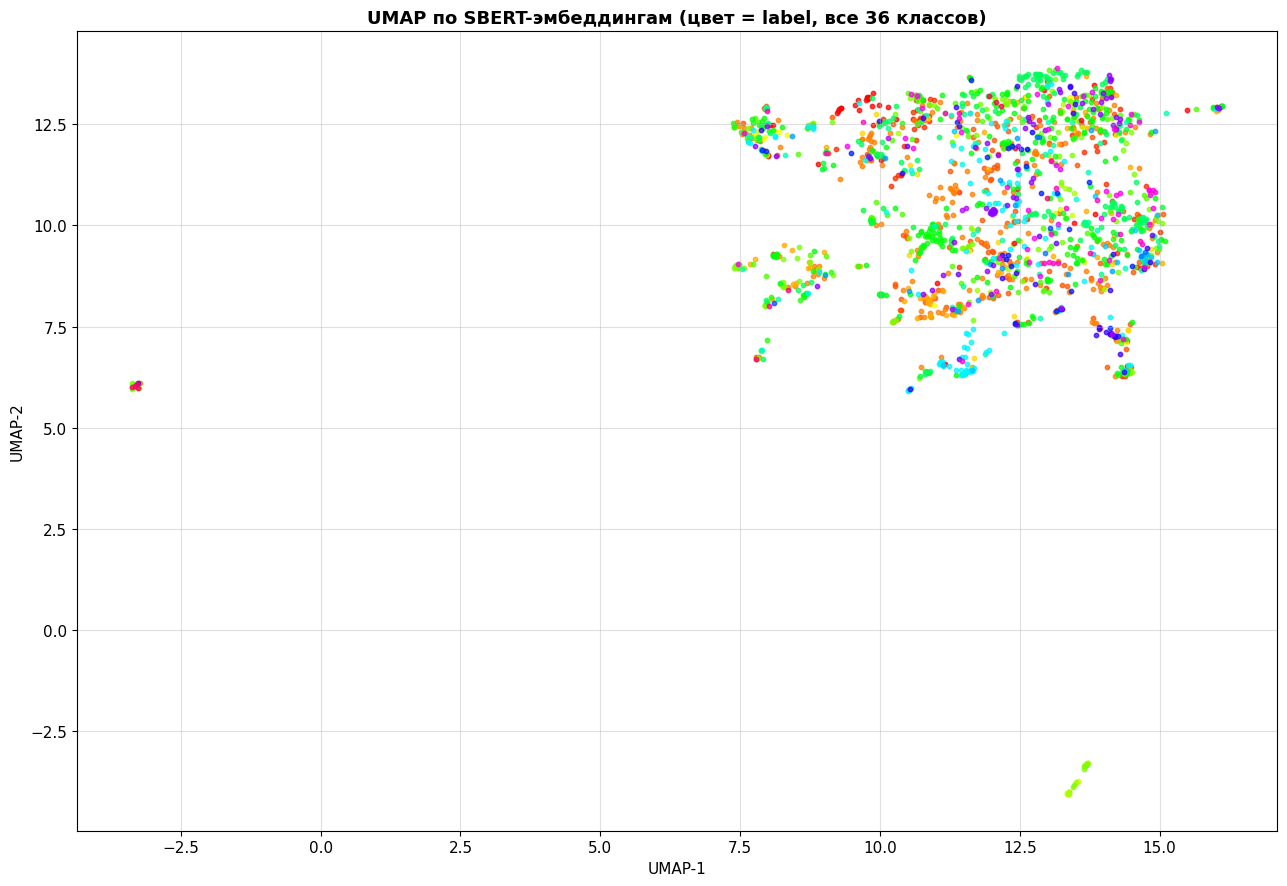

In [ ]:
# --- График 2: цвет = label, все классы ---
# Показываем ВСЕ 36 классов

all_labels = df['label'].unique().tolist()
cmap_all = plt.cm.get_cmap('hsv', len(all_labels))
color_map_all = {lbl: cmap_all(i) for i, lbl in enumerate(all_labels)}

fig, ax = plt.subplots(figsize=(13, 9))
for lbl in all_labels:
    mask = df['label'] == lbl
    ax.scatter(
        embedding_2d[mask, 0],
        embedding_2d[mask, 1],
        c=[color_map_all[lbl]],
        s=10, alpha=0.75
    )

ax.set_title('UMAP по SBERT-эмбеддингам (цвет = label, все 36 классов)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
plt.tight_layout()
plt.savefig('umap_all_labels.png', dpi=150, bbox_inches='tight')
plt.show()